In [14]:
import torch
from torch import nn

# Import PyTorch
import torch
from torch import nn

## Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image

import pandas as pd

import os
from tqdm.auto import tqdm
from pathlib import Path

from PIL import Image
# from torchinfo import summary


In [15]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [107]:
image_path = Path("pizza_steak_sushi_20_percent")
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('pizza_steak_sushi_20_percent/train'),
 WindowsPath('pizza_steak_sushi_20_percent/test'))

In [108]:
def walk_through_dir(dir_path):
  """Walks through dir_path returnning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dir_path}'.")

Random image path: pizza_steak_sushi_20_percent\train\sushi\20588.jpg
Image class: sushi
Image height: 512
Image width: 384


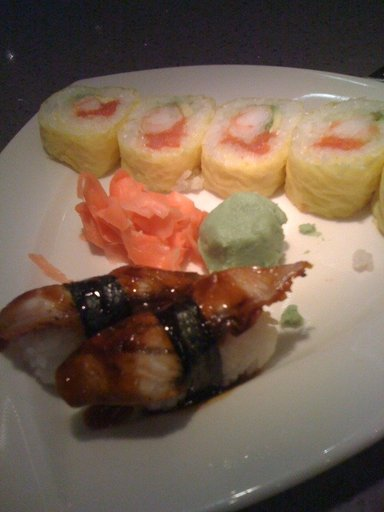

In [109]:
import random
from PIL import Image

# Set the seed
# random.seed(42)

# 1. Get all the image paths ()
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [110]:
# Write a transform for image
data_transform = transforms.Compose([
  # Resize our images to 224 x 224
  transforms.Resize(size=(224, 224)),
  # Flip the images randomly on the horizontal
  transforms.RandomHorizontalFlip(p=0.5),
  # Turn the image into a torch.Tensor
  transforms.ToTensor()
])

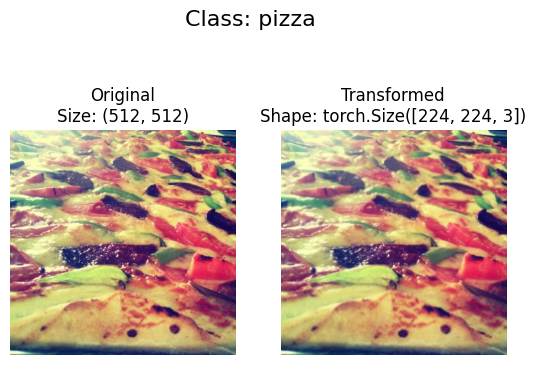

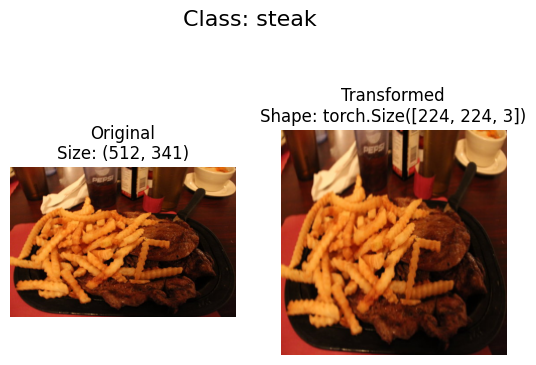

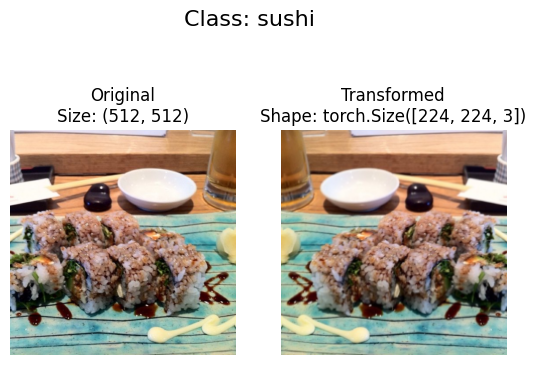

In [111]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """
  Selects random images from a path of images and loads/transforms 
  them then plots the original vs the transform version.
  """

  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=52)

In [112]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 450
     Root location: pizza_steak_sushi_20_percent\train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 150
     Root location: pizza_steak_sushi_20_percent\test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [113]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x14ae53de870>,
 <torch.utils.data.dataloader.DataLoader at 0x14ae1df02f0>)

In [114]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions").is_file():
  print("helper_functions.py already exists, skipping download...")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [115]:
class HotdogNotHotdogModelV0(nn.Module):
    # Issue: train accuracy can reach 100%, but test loss is stuck at around 60%
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*56*56, # there's a trick to calculating this...
                    out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(f"Output shape of conv_block_1: {x.shape}")
        x = self.conv_block_2(x)
        # print(f"Output shape of conv_block_2: {x.shape}")
        x = self.classifier(x)
        return x

In [116]:
class HotdogNotHotdogModelV1(nn.Module):
    # Improvment: changed the kernel sizes
    # Issue: able to get to 100% train accuracy, but test accuracy is ranging from 60-70%
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=2,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=2,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=4,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*56*56, # there's a trick to calculating this...
                    out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(f"Output shape of conv_block_1: {x.shape}")
        x = self.conv_block_2(x)
        # print(f"Output shape of conv_block_2: {x.shape}")
        x = self.classifier(x)
        return x

In [117]:
class HotdogNotHotdogModelV2(nn.Module):
    # Improvment: added another conv block, still bad
    # Issue: able to get to 100% train accuracy, but test accuracy is ranging from 60-70%
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=2,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=2,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*26*26, # there's a trick to calculating this...
                    out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(f"Output shape of conv_block_1: {x.shape}")
        x = self.conv_block_2(x)
        # print(f"Output shape of conv_block_2: {x.shape}")
        x = self.conv_block_3(x)
        # print(f"Output shape of conv_block_3: {x.shape}")
        x = self.classifier(x)
        return x

In [118]:
class HotdogNotHotdogModelV3(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units = 64):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.prev = hidden_units
        hidden_units *= 2

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=self.prev,
                      out_channels=hidden_units,
                      kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.prev = hidden_units
        hidden_units *= 2

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=self.prev,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.prev = hidden_units
        hidden_units *= 2

        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(in_channels=self.prev,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.prev = hidden_units
        hidden_units *= 2

        self.conv_block_5 = nn.Sequential(
            nn.Conv2d(in_channels=self.prev,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=hidden_units*8),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units*8,
                      out_features=hidden_units*8),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units*8,
                      out_features=1)
        )
    
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = self.conv_block_5(x)
        print(x.shape)
        x = self.classifier(x)

        return x

In [119]:
class HotdogNotHotdogModelV4(nn.Module):
    # Improvment: added another conv block, still bad
    # Issue: able to get to 100% train accuracy, but test accuracy is ranging from 60-70%
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout()
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout()
        )

        # self.conv_block_3 = nn.Sequential(
        #     nn.Conv2d(
        #         in_channels=hidden_units,
        #         out_channels=hidden_units,
        #         kernel_size=3,
        #     ),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2),
        #     nn.Dropout()
        # )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(),
            nn.Linear(in_features=hidden_units*54*54, # there's a trick to calculating this...
                    out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(f"Output shape of conv_block_1: {x.shape}")
        x = self.conv_block_2(x)
        # print(f"Output shape of conv_block_2: {x.shape}")
        # x = self.conv_block_3(x)
        # print(f"Output shape of conv_block_3: {x.shape}")
        x = self.classifier(x)
        return x

In [120]:
class HotdogNotHotdogModelV5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3,
                      out_channels=32,
                      kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=32,
                      out_channels=64,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.5)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.5)
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.25)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=676*128,
                      out_features=64),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(in_features=64,
                      out_features=1)
        )



    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [121]:
class PizzaSteakSushiModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3,
                      out_channels=32,
                      kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=32,
                      out_channels=64,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.5)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.5)
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.25)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=676*128,
                      out_features=64),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(in_features=64,
                      out_features=3)
        )



    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [122]:
# model_0 = HotdogNotHotdogModelV0(input_shape=3, hidden_units=16, output_shape=1).to(device)
# model_1 = HotdogNotHotdogModelV1(input_shape=3, hidden_units=16, output_shape=1).to(device)
# model_2 = HotdogNotHotdogModelV2(input_shape=3, hidden_units=16, output_shape=1).to(device)
# model_3 = HotdogNotHotdogModelV3(input_shape=3, output_shape=1).to(device)
# model_4 = HotdogNotHotdogModelV4(input_shape=3, hidden_units=16, output_shape=1).to(device)
# model_5 = HotdogNotHotdogModelV5().to(device)

In [123]:
pizza_steak_sushi_modelV0 = PizzaSteakSushiModelV0()

In [124]:
def train_step(model: nn.Module, data_loader: DataLoader, loss_fn: nn.Module, optimizer: torch.optim.Optimizer, accuracy_fn):

    device = next(model.parameters()).device
    train_loss = 0
    train_accuracy = 0

    model.train()

    for X, y in data_loader:
        X, y = X.to(device), y.type(torch.int64).to(device)

        y_logits = model(X)
        y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
        # print(y_preds)

        # print(y_logits)

        # print(y_logits.dtype)
        # print(y.dtype)
        # print(X.shape)
        # print(f"y_logits shape: {y_logits.shape} | y shape: {y.shape}")

        loss = loss_fn(y_logits, y)
        train_loss += loss

        # print(y_logits)

        acc = accuracy_fn(y, y_preds)
        train_accuracy += acc

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(data_loader)
    train_accuracy /= len(data_loader)

    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_accuracy:.2f}%")



In [125]:
def test_step(model: nn.Module, data_loader: DataLoader, loss_fn: nn.Module, accuracy_fn):
    
    device = next(model.parameters()).device
    test_loss = 0
    test_acc = 0

    model.train

    with torch.inference_mode():
        for X, y in data_loader:
            
            X, y = X.to(device), y.type(torch.int64).to(device)

            y_logits = model(X)
            y_preds  = torch.softmax(y_logits, dim=1).argmax(dim=1)
            # print(f"y_logits shape: {y_logits.shape} | y shape: {y.shape}")
            loss = loss_fn(y_logits, y)
            test_loss += loss

            acc = accuracy_fn(y, y_preds)
            test_acc += acc

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")




In [126]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [148]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=pizza_steak_sushi_modelV0.parameters(),
                            lr=0.0001)

In [149]:
from helper_functions import accuracy_fn

epochs = 10

start_time = timer()

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----------")
    train_step(model=pizza_steak_sushi_modelV0,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn)
    
    test_step(model=pizza_steak_sushi_modelV0,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn)
    
    
end_time = timer()

train_time = print_train_time(start_time, end_time, device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
----------
Train loss: 0.89633 | Train accuracy: 50.21%
Test loss: 0.94081 | Test acc: 49.38%

Epoch: 1
----------
Train loss: 0.85489 | Train accuracy: 57.92%
Test loss: 0.92972 | Test acc: 55.62%

Epoch: 2
----------
Train loss: 0.82987 | Train accuracy: 62.50%
Test loss: 0.90056 | Test acc: 54.66%

Epoch: 3
----------
Train loss: 0.89563 | Train accuracy: 52.08%
Test loss: 0.87694 | Test acc: 57.95%

Epoch: 4
----------
Train loss: 0.86244 | Train accuracy: 55.83%
Test loss: 0.94451 | Test acc: 56.53%

Epoch: 5
----------
Train loss: 0.81619 | Train accuracy: 60.00%
Test loss: 0.95473 | Test acc: 54.09%

Epoch: 6
----------
Train loss: 0.84878 | Train accuracy: 57.29%
Test loss: 0.95910 | Test acc: 51.48%

Epoch: 7
----------
Train loss: 0.86384 | Train accuracy: 58.96%
Test loss: 0.94345 | Test acc: 51.93%

Epoch: 8
----------
Train loss: 0.86521 | Train accuracy: 58.75%
Test loss: 0.92567 | Test acc: 54.38%

Epoch: 9
----------
Train loss: 0.88446 | Train accuracy: 58.96%

In [142]:
def eval_model(model: nn.Module, data: Dataset, ncols, nrows, n):
    plt.figure(figsize=(15, 15))
    for i in range(n):
        classes = data.classes
        rand_int = torch.randint(0, len(data), size=(1,)).item()
        X, y = data[rand_int]
        X_permute = X.permute(1, 2, 0)
        
        device = next(model.parameters()).device

        X, y = X.to(device), y

        model.eval()
        with torch.inference_mode():
            # X.to("cuda")
            # # print(X.device)
            # y_logit = (model(X.unsqueeze(0)))
            # y_pred = torch.round(torch.sigmoid(y_logit))
            y_logit = model(X.unsqueeze(0))
            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

        y_pred = y_pred.type(torch.int).item()
        y_pred = classes[y_pred]
        y_actual = classes[y]

        # plt.figure(figsize=(3, 3))
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(X_permute)
        plt.axis("off")

        if y_pred == y_actual:
            plt.title(f"True: {y_actual} | Pred: {y_pred}", fontsize=10, c="g")
        else:
            plt.title(f"True: {y_actual} | Pred: {y_pred}", fontsize=10, c="r")

In [42]:
# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "hotdog_nothotdog_V5_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Sve the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_5.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models\hotdog_nothotdog_V5_2.pth


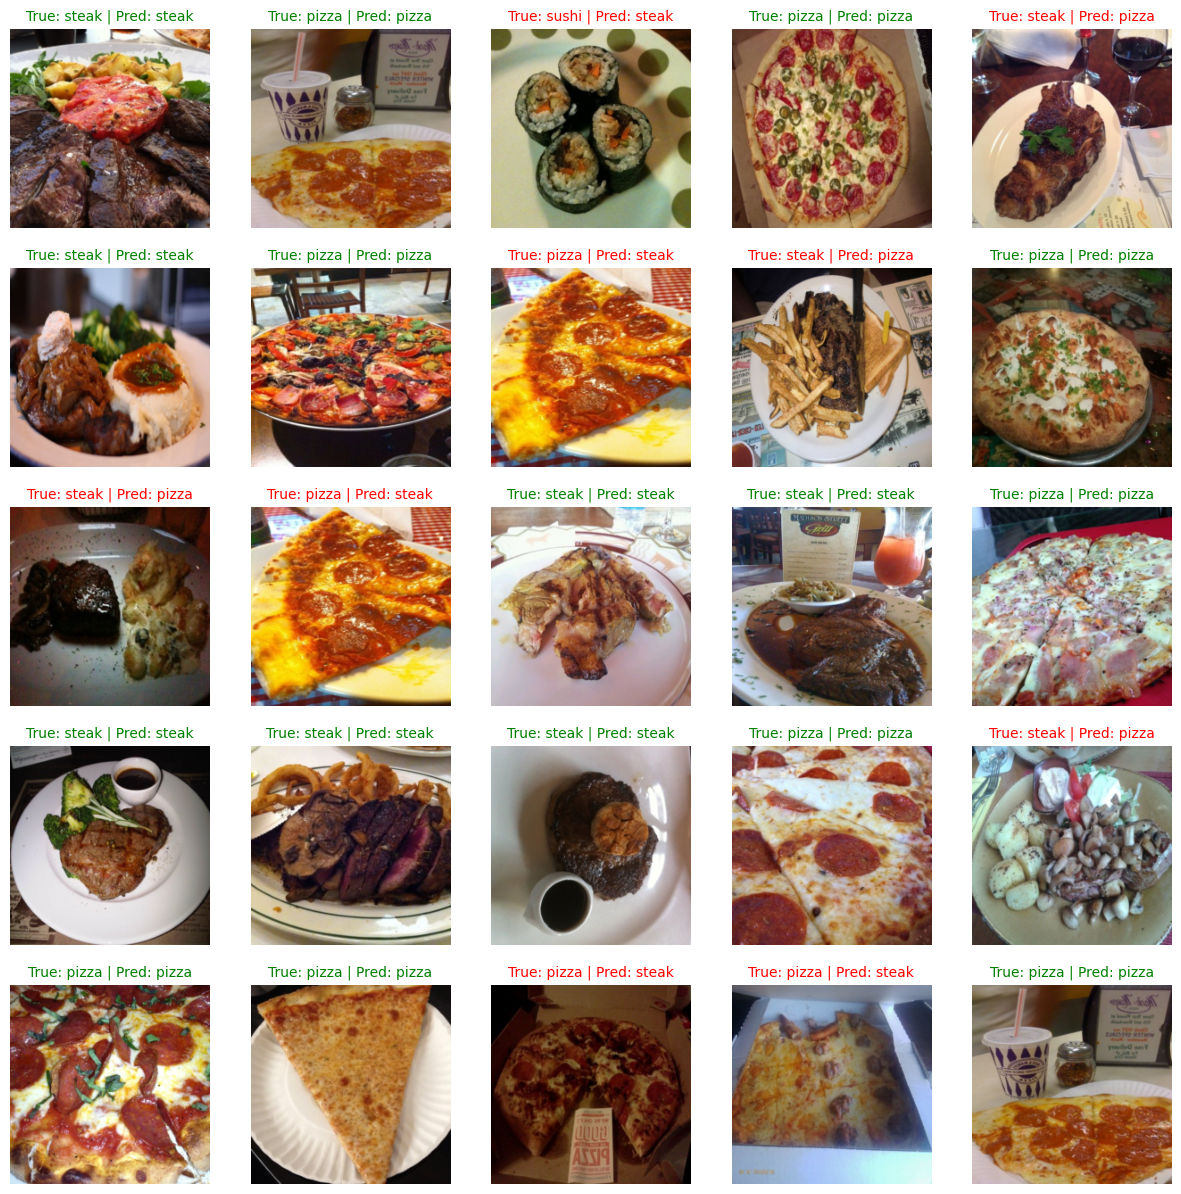

In [147]:
eval_model(pizza_steak_sushi_modelV0, test_data, 5, 5, 25)